# Script to do the extraction face information

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

from deepface import DeepFace
from deepface.detectors import FaceDetector
from deepface.DeepFace import build_model
from deepface.commons.functions import load_image
from tensorflow import keras

from deepface.extendedmodels import Age, Gender, Race, Emotion

In [310]:
detections_path = '../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/face_detection_results_1_HQ.npy'
face_detections = np.load(detections_path, allow_pickle=True)
face_detections = face_detections[0]
face = face_detections['02032']['face_1']['facial_area']


In [311]:
image_path = '../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/1_HQ/frames/02032.jpg'
frame = cv2.imread(image_path)
#cv2.rectangle(image, (face[3], face[0]), (face[1],face[2]), (0,0,255), 3) #3012 para face_locations
#cv2.rectangle(frame, (face[0], face[1]), (face[2],face[3]), (0,255,100), 3) 
#fig = plt.figure(figsize=(15,7.5)) 
#plt.imshow(frame)
#plt.show() 

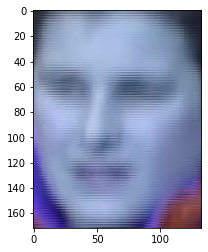

In [312]:
frame_face = frame[face[1]:face[3],face[0]:face[2],:]
plt.imshow(frame_face)
plt.show() 


## Model Code

In [313]:
# analyze output (emotions)
DeepFace.analyze(frame_face, actions = ['emotion'], enforce_detection=False)

{'emotion': {'angry': 4.809475145873445,
  'disgust': 0.0005139692051370472,
  'fear': 0.8499127894536006,
  'happy': 5.698975854989988,
  'sad': 20.025817456938917,
  'surprise': 0.013030906946357423,
  'neutral': 68.60227806595303},
 'dominant_emotion': 'neutral',
 'region': {'x': 0, 'y': 0, 'w': 172, 'h': 133}}

In [124]:
from tensorflow.keras.preprocessing import image

def preprocess_face(img, target_size=(224, 224), grayscale = False, align = True):

    #img might be path, base64 or numpy array. Convert it to numpy whatever it is.
    img = load_image(img)
    base_img = img.copy()

    # img, region = detect_face(img = img, detector_backend = detector_backend, grayscale = grayscale, enforce_detection = enforce_detection, align = align)

    #--------------------------

    if img.shape[0] == 0 or img.shape[1] == 0:
        if enforce_detection == True:
            raise ValueError("Detected face shape is ", img.shape,". Consider to set enforce_detection argument to False.")
        else: #restore base image
            img = base_img.copy()

    #--------------------------

    #post-processing
    if grayscale == True:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #---------------------------------------------------
    #resize image to expected shape

    # img = cv2.resize(img, target_size) #resize causes transformation on base image, adding black pixels to resize will not deform the base image

    if img.shape[0] > 0 and img.shape[1] > 0:
        factor_0 = target_size[0] / img.shape[0]
        factor_1 = target_size[1] / img.shape[1]
        factor = min(factor_0, factor_1)

        dsize = (int(img.shape[1] * factor), int(img.shape[0] * factor))
        img = cv2.resize(img, dsize)

        # Then pad the other side to the target size by adding black pixels
        diff_0 = target_size[0] - img.shape[0]
        diff_1 = target_size[1] - img.shape[1]
        if grayscale == False:
            # Put the base image in the middle of the padded image
            img = np.pad(img, ((diff_0 // 2, diff_0 - diff_0 // 2), (diff_1 // 2, diff_1 - diff_1 // 2), (0, 0)), 'constant')
        else:
            img = np.pad(img, ((diff_0 // 2, diff_0 - diff_0 // 2), (diff_1 // 2, diff_1 - diff_1 // 2)), 'constant')

    #------------------------------------------

    #double check: if target image is not still the same size with target.
    if img.shape[0:2] != target_size:
        img = cv2.resize(img, target_size)

    #---------------------------------------------------

    #normalizing the image pixels

    img_pixels = image.img_to_array(img) #what this line doing? must?
    img_pixels = np.expand_dims(img_pixels, axis = 0)
    img_pixels /= 255 #normalize input in [0, 1]

    #---------------------------------------------------


    return img_pixels

In [212]:
# using our model directly using the library funcionts (layer 13 is the same than analyze output), 8 is the flatten vect
# we have to go deeper
model = build_model('Emotion')
img = preprocess_face(img = frame_face, target_size = (48, 48), grayscale = True)
extractor = keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])
features = extractor(img)
vector = features[13].numpy()[0] # paraleliza!!
vector

array([3.3504343e-01, 2.1237863e-08, 2.8534378e-03, 4.0410592e-05,
       1.9259226e-01, 1.3949553e-05, 4.6945652e-01], dtype=float32)

In [130]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 44, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
average_pooling2d (AveragePo (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 128)         1

## Generator Code

In [10]:
from multiprocessing import Pool
from pathlib import Path

In [131]:
# we will only read the images that have a face
faces_frames = [k for k, v in face_detections.items() if len(v) > 0]


In [132]:
def load_image1(frame_idx, frame_path):
    # frame_idx, frame_path = arg
    img = cv2.imread(frame_path)
    return frame_idx, img

class FaceFeeder:

    def __init__(self, directory, valid_frames, batch_size, num_processes=10):

        self.directory = Path(directory)
        self.valid_frames = valid_frames
        self.batch_size = batch_size
        self.num_processes = num_processes

        batch_list = []
        for i in range(0, len(self.valid_frames), self.batch_size):
            batch_list.append(self.valid_frames[i:i + self.batch_size])
        self.batch_list = batch_list

    def __len__(self):
        return int(np.ceil(len(self.valid_frames) / self.batch_size))

    def __getitem__(self, index):

        batch = np.zeros([self.batch_size, 1024, 1820, 3])  # FIXME: revisar size mas videos
        im_infos = [None] * self.batch_size
        im_scales = [None] * self.batch_size



        frame_paths, frame_indices = [], []
        for idx, num in enumerate(self.batch_list[index]):
            # frame_paths.append(str(self.directory.joinpath(str(f'{num:05}') + '.jpg')))
            #TODO: keep in mind now num is a string
            frame_paths.append(str(self.directory.joinpath(str(f'{num}') + '.jpg')))
            frame_indices.append(idx)
        
        batch = np.zeros([self.batch_size, 1080, 1920, 3])
        
        for path, index in zip(frame_paths, frame_indices):
            im_id, im = load_image1(index, str(path))
            batch[im_id,:,:,:] = im        

        return batch.astype(np.uint8)

In [309]:
frames_dir = Path('../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/1_HQ/frames')
l = FaceFeeder(frames_dir, faces_frames, 2)
n_batch = 100
b = l.__getitem__(n_batch)
bl = l.batch_list[n_batch]
# print(bl[0])
# face_detections[bl[0]]
bl


['02032', '02033']

In [226]:
# given a frame and a list of faces, get a preprocessed batch of faces

def frame_to_faces(image, faces):
    faces_batch = np.zeros([len(faces),48,48,1])
    
    for f in range(0,len(faces)):
        area = faces[f'face_{f+1}']['facial_area']
        face = image[area[1]:area[3], area[0]:area[2],:]
        face = preprocess_face(img = face, target_size = (48, 48), grayscale = True)
        faces_batch[f-1,:,:,:] = face
        
    return faces_batch

faces_batch = frame_to_faces(b[0], face_detections[bl[0]])
faces_batch.shape

(14, 48, 48, 1)

In [304]:
# given a frame batch --> faces batch of all frames
def frame_batch_to_faces(frame_batch, faces, batch_list):

    num_faces = num_batch_faces(batch_list, faces)
    big_batch = np.zeros([num_faces, 48, 48, 1])
    first_len = 0
    for i in range(len(frame_batch)):
        faces_frame = frame_to_faces(frame_batch[i], faces[batch_list[i]])
        
        big_batch[first_len:first_len+len(faces_frame),:,:,:] = faces_frame[:,:,:,:]
        first_len = len(faces_frame)

    return big_batch
    
faces_total_batch = frame_batch_to_faces(b, face_detections, bl)

faces_total_batch.shape

(29, 48, 48, 1)

In [308]:
features = extractor(faces_total_batch)
vector = features[13].numpy()
vector

array([[1.34744696e-04, 5.85326718e-11, 3.93464509e-03, 7.88217818e-04,
        1.68267433e-02, 4.16935563e-06, 9.78311479e-01],
       [4.28632193e-04, 2.50561778e-13, 8.06772485e-02, 9.23442922e-09,
        8.37838113e-01, 1.70884448e-07, 8.10557753e-02],
       [9.94333148e-01, 8.23036557e-16, 2.00082759e-05, 5.43911758e-13,
        5.45936124e-03, 5.83153914e-13, 1.87464218e-04],
       [1.01623371e-01, 5.61447960e-05, 5.91886453e-02, 3.36373269e-05,
        6.32772505e-01, 6.66765482e-06, 2.06319094e-01],
       [1.70540377e-01, 5.72708677e-12, 2.33278081e-01, 1.20073828e-05,
        7.02910870e-02, 1.19891840e-04, 5.25758564e-01],
       [8.85255344e-04, 2.85363244e-09, 1.94439280e-03, 8.81062224e-05,
        3.24029595e-01, 9.39765016e-07, 6.73051715e-01],
       [5.32653034e-01, 1.91432027e-05, 5.58912056e-03, 6.96966425e-02,
        2.94108428e-02, 8.50924640e-04, 3.61780256e-01],
       [4.73459613e-06, 8.81611949e-13, 5.72876167e-03, 3.34455677e-07,
        1.99258909e-01, 8

In [265]:
def num_batch_faces(batch_list, faces):
    count = 0
    for frame in batch_list:
        count += len(faces[frame])
    return count
        
num_batch_faces(bl, face_detections)

29

In [288]:
prova = np.zeros([3,3,3])
prova[:,:,:] = 3
prova[:2,:,:] = np.zeros([2,3,3])
prova

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]]])